Dataset shape: (307511, 33)
Training set: (246008, 32)
Testing set: (61503, 32)

Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
2              XGBoost  0.919581   0.579832  0.013897  0.027144  0.750489
0  Logistic Regression  0.919370   0.551724  0.006445  0.012741  0.736265
1        Random Forest  0.919288   0.521739  0.002417  0.004812  0.717712


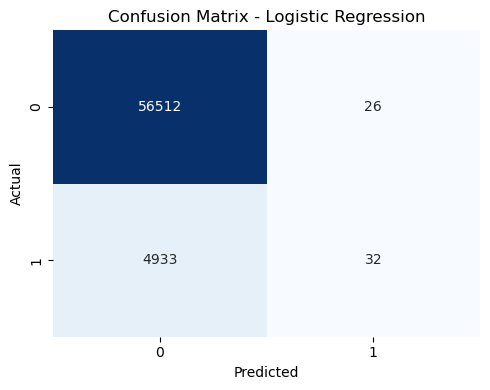

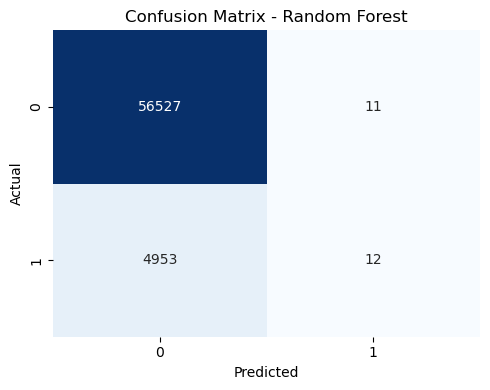

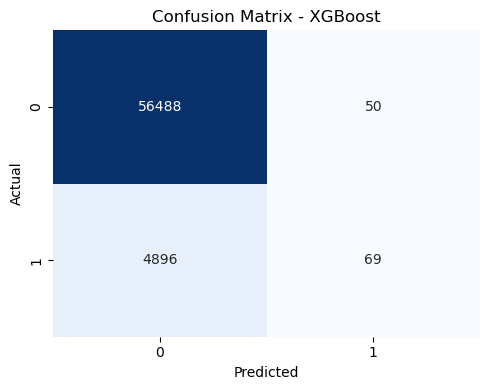

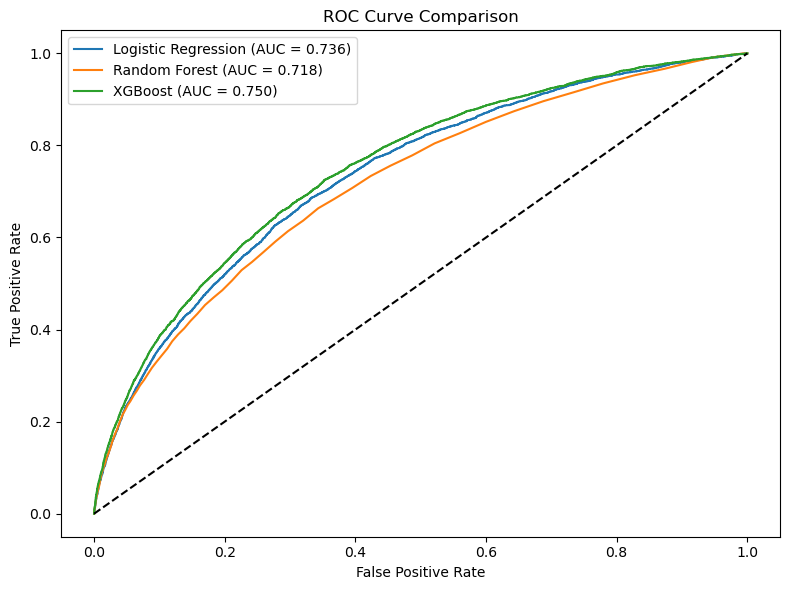


Best Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.58      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503


Best model saved as: models/xgboost_model.pkl


In [3]:
# 🤖 Project 1: Model Training & Evaluation
# CSCD613 - Machine Learning with Big Data Analytics (Group 10)
# -------------------------------------------------------------
# Objective:
#   Train and evaluate multiple machine learning models
#   to predict loan default using the engineered dataset.
#
# Main Tasks:
#   1. Load the feature-engineered dataset
#   2. Split data into train and test sets
#   3. Train multiple models (Logistic Regression, Random Forest, XGBoost)
#   4. Evaluate models using accuracy, precision, recall, F1, and ROC-AUC
#   5. Visualize confusion matrices and ROC curves
#   6. Select the best-performing model

# -------------------------------------------------------------
# Step 1: Import Libraries
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------
# Step 2: Load Feature-Engineered Dataset
# -------------------------------------------------------------

data = pd.read_csv('data/featured_application_train.csv')
print("Dataset shape:", data.shape)
data.head()

# Separate features and target
X = data.drop(columns=['TARGET'])
y = data['TARGET']

# -------------------------------------------------------------
# Step 3: Split Dataset
# -------------------------------------------------------------
# We'll use 80% of data for training and 20% for testing.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

# -------------------------------------------------------------
# Step 4: Initialize Models
# -------------------------------------------------------------

models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False
    )
}

# -------------------------------------------------------------
# Step 5: Train and Evaluate Models
# -------------------------------------------------------------

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc
    })

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.sort_values(by='ROC-AUC', ascending=False))

# -------------------------------------------------------------
# Step 6: Confusion Matrix Visualization
# -------------------------------------------------------------

def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Confusion Matrix - {name}")

# -------------------------------------------------------------
# Step 7: ROC Curve Comparison
# -------------------------------------------------------------

plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# Step 8: Classification Report for Best Model
# -------------------------------------------------------------

best_model_name = results_df.sort_values(by='ROC-AUC', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

print(f"\nBest Model: {best_model_name}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# -------------------------------------------------------------
# Step 9: Save Best Model (Optional)
# -------------------------------------------------------------

import joblib
joblib.dump(best_model, f"models/{best_model_name.replace(' ', '_').lower()}_model.pkl")
print(f"\nBest model saved as: models/{best_model_name.replace(' ', '_').lower()}_model.pkl")

# -------------------------------------------------------------
# Summary:
# -------------------------------------------------------------
# - Trained Logistic Regression, Random Forest, and XGBoost models
# - Evaluated each model using multiple metrics
# - Visualized confusion matrices and ROC curves
# - Saved the best-performing model for deployment
#
# Next notebook → project1_04_model_interpretation.ipynb
